# Natural language inference: models

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Fall 2020"

## Contents

1. [Overview](#Overview)
1. [Set-up](#Set-up)
1. [Sparse feature representations](#Sparse-feature-representations)
  1. [Feature representations](#Feature-representations)
  1. [WordNet features](#WordNet-features)
  1. [Model wrapper for hyperparameter search](#Model-wrapper-for-hyperparameter-search)
  1. [Assessment](#Assessment)
1. [Hypothesis-only baselines](#Hypothesis-only-baselines)
1. [Sentence-encoding models](#Sentence-encoding-models)
  1. [Dense representations](#Dense-representations)
  1. [Sentence-encoding RNNs](#Sentence-encoding-RNNs)
  1. [Other sentence-encoding model ideas](#Other-sentence-encoding-model-ideas)
1. [Chained models](#Chained-models)
  1. [Simple RNN](#Simple-RNN)
  1. [Separate premise and hypothesis RNNs](#Separate-premise-and-hypothesis-RNNs)
1. [Attention mechanisms](#Attention-mechanisms)
1. [Error analysis with the MultiNLI annotations](#Error-analysis-with-the-MultiNLI-annotations)

## Overview

This notebook defines and explores a number of models for NLI. The general plot is familiar from [our work with the Stanford Sentiment Treebank](sst_01_overview.ipynb):

1. Models based on sparse feature representations
1. Linear classifiers and feed-forward neural classifiers using dense feature representations
1. Recurrent neural networks (and, briefly, tree-structured neural networks)

The twist here is that, while NLI is another classification problem, the inputs have important high-level structure: __a premise__ and __a hypothesis__. This invites exploration of a host of neural designs:

* In __sentence-encoding__ models, the premise and hypothesis are analyzed separately, and combined only for the final classification step.

* In __chained__ models, the premise is processed first, then the hypotheses, giving a unified representation of the pair.

NLI resembles sequence-to-sequence problems like __machine translation__ and __language modeling__. The central modeling difference is that NLI doesn't produce an output sequence, but rather consumes two sequences to produce a label. Still, there are enough affinities that many ideas have been shared among these areas.

## Set-up

See [the previous notebook](nli_01_task_and_data.ipynb#Set-up) for set-up instructions for this unit. 

In [1]:
from collections import Counter
from itertools import product
import nli
import numpy as np
import os
import pandas as pd
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.utils.data
from torch_model_base import TorchModelBase
from torch_rnn_classifier import TorchRNNClassifier, TorchRNNModel
from torch_shallow_neural_classifier import TorchShallowNeuralClassifier
import utils
import warnings

In [2]:
utils.fix_random_seeds()

In [3]:
GLOVE_HOME = os.path.join('data', 'glove.6B')

DATA_HOME = os.path.join("data", "nlidata")

SNLI_HOME = os.path.join(DATA_HOME, "snli_1.0")

MULTINLI_HOME = os.path.join(DATA_HOME, "multinli_1.0")

ANNOTATIONS_HOME = os.path.join(DATA_HOME, "multinli_1.0_annotations")

## Sparse feature representations

We begin by looking at models based in sparse, hand-built feature representations. As in earlier units of the course, we will see that __these models are competitive__: easy to design, fast to optimize, and highly effective.

### Feature representations

The guiding idea for NLI sparse features is that one wants to knit together the premise and hypothesis, so that the model can learn about their relationships rather than just about each part separately.

With `word_overlap_phi`, we just get the set of words that occur in both the premise and hypothesis.

In [6]:
def word_overlap_phi(t1, t2):
    """
    Basis for features for the words in both the premise and hypothesis.
    Downcases all words.

    Parameters
    ----------
    t1, t2 : `nltk.tree.Tree`
        As given by `str2tree`.

    Returns
    -------
    defaultdict
       Maps each word in both `t1` and `t2` to 1.

    """
    words1 = {w.lower() for w in t1.leaves()}
    words2 = {w.lower() for w in t2.leaves()}
    return Counter(words1 & words2)

With `word_cross_product_phi`, we count all the pairs $(w_{1}, w_{2})$ where $w_{1}$ is a word from the premise and $w_{2}$ is a word from the hypothesis. This creates a very large feature space. These models are very strong right out of the box, and they can be supplemented with more fine-grained features.

In [7]:
def word_cross_product_phi(t1, t2):
    """
    Basis for cross-product features. Downcases all words.

    Parameters
    ----------
    t1, t2 : `nltk.tree.Tree`
        As given by `str2tree`.

    Returns
    -------
    defaultdict
        Maps each (w1, w2) in the cross-product of `t1.leaves()` and
        `t2.leaves()` (both downcased) to its count. This is a
        multi-set cross-product (repetitions matter).

    """
    words1 = [w.lower() for w in t1.leaves()]
    words2 = [w.lower() for w in t2.leaves()]
    return Counter([(w1, w2) for w1, w2 in product(words1, words2)])

### WordNet features
Whole class of features could come from WordNet. WordNet is a very high-fidelity, handcrafted resource, full of information about word-level relationships, in particular entailment relationship in the form of hypernyms and some contradiction information in the form of antonyms.

In [22]:
from collections import Counter
from itertools import product
from nltk.corpus import wordnet as wn
from nltk.tree import Tree

##### Entailment: hypernyms

In [12]:
puppies = wn.synsets('puppy')
puppies

[Synset('puppy.n.01'), Synset('puppy.n.02')]

In [13]:
[h for ss in puppies for h in ss.hypernyms()]

[Synset('dog.n.01'), Synset('pup.n.01'), Synset('young_person.n.01')]

The meaning of puppy is ambiguous and WordNet get that

A more conservative approach uses just the first-listed Synset, which should be the most frequent sense:

In [14]:
puppies[0].hypernyms()

[Synset('dog.n.01'), Synset('pup.n.01')]

##### Contradiction: antonyms

In [23]:
wn.synsets('happy')[0].lemmas()[0].antonyms()

[Lemma('unhappy.a.01.unhappy')]

##### A is entailed by B: hyponyms

In [28]:
wn.synsets('spoon')[0].hyponyms()

[Synset('dessert_spoon.n.01'),
 Synset('runcible_spoon.n.01'),
 Synset('soupspoon.n.01'),
 Synset('sugar_spoon.n.01'),
 Synset('tablespoon.n.02'),
 Synset('tea_maker.n.01'),
 Synset('teaspoon.n.02'),
 Synset('wooden_spoon.n.02')]

##### An example of feature using WordNet

In [34]:
def wordnet_features(t1, t2, methodname):
    """This feature look at overlaps between premise and hypothesis"""
    pairs = []
    words1 = t1.leaves()
    words2 = t2.leaves()
    for w1, w2 in product(words1, words2):
        hyps = [h for ss in wn.synsets(w1) for h in getattr(ss, methodname)()]
        syns = wn.synsets(w2)
        if set(hyps) & set(syns):
            # if there is an intersection between hyps and syns add it to pairs
            pairs.append((w1, w2))
    return Counter(pairs)

def hypernym_features(t1, t2):
    return wordnet_features(t1, t2, 'hypernyms')

def hyponym_features(t1, t2):
    return wordnet_features(t1, t2, 'hyponyms')

In [35]:
t1 = Tree.fromstring("""(S (NP (D the) (N puppy)) (VP moved))""")

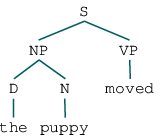

In [36]:
display(t1)

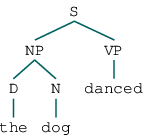

In [37]:
t2 = Tree.fromstring("""(S (NP (D the) (N dog)) (VP danced))""")
display(t2)

In [38]:
hypernym_features(t1, t2)

Counter({('puppy', 'dog'): 1})

In [39]:
hyponym_features(t1, t2)

Counter({('moved', 'danced'): 1})

### Model wrapper for hyperparameter search

Our experiment framework is basically the same as the one we used for the Stanford Sentiment Treebank. 

For a full evaluation, we would like to search for the best hyperparameters. However, SNLI is very large, so each evaluation is very expensive. To try to keep this under control, we can set the optimizer to do just a few epochs of training during the search phase. The assumption here is that the best parameters actually emerge as best early in the process. This is by no means guaranteed, but it seems like a good way to balance doing serious hyperparameter search with the costs of doing dozens or even thousands of experiments. (See also [the discussion of hyperparameter search in the evaluation methods notebook](evaluation_methods.ipynb#Hyperparameter-optimization).)

In [7]:
def fit_softmax_with_hyperparameter_search(X, y):
    """
    A MaxEnt model of dataset with hyperparameter cross-validation.

    Parameters
    ----------
    X : 2d np.array
        The matrix of features, one example per row.

    y : list
        The list of labels for rows in `X`.

    Returns
    -------
    sklearn.linear_model.LogisticRegression
        A trained model instance, the best model found.

    """

    mod = LogisticRegression(
        fit_intercept=True,
        max_iter=3,  ## A small number of iterations.
        solver='liblinear',
        multi_class='ovr')

    param_grid = {
        'C': [0.4, 0.6, 0.8, 1.0],
        'penalty': ['l1','l2']}

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        bestmod = utils.fit_classifier_with_hyperparameter_search(
            X, y, mod, param_grid=param_grid, cv=3)

    return bestmod

### Assessment

In [8]:
%%time
word_cross_product_experiment_xval = nli.experiment(
    train_reader=nli.SNLITrainReader(SNLI_HOME),
    phi=word_cross_product_phi,
    train_func=fit_softmax_with_hyperparameter_search,
    assess_reader=None,
    verbose=False)

Best params: {'C': 0.4, 'penalty': 'l1'}
Best score: 0.704
CPU times: user 18min 40s, sys: 7min 11s, total: 25min 52s
Wall time: 10min 35s


In [9]:
optimized_word_cross_product_model = word_cross_product_experiment_xval['model']

In [10]:
# `word_cross_product_experiment_xval` consumes a lot of memory, and we
# won't make use of it outside of the model, so we can remove it now.
del word_cross_product_experiment_xval

In [11]:
def fit_optimized_word_cross_product(X, y):
    optimized_word_cross_product_model.max_iter = 1000 # To convergence in this phase!
    optimized_word_cross_product_model.fit(X, y)
    return optimized_word_cross_product_model

In [12]:
%%time
_ = nli.experiment(
    train_reader=nli.SNLITrainReader(SNLI_HOME),
    phi=word_cross_product_phi,
    train_func=fit_optimized_word_cross_product,
    assess_reader=nli.SNLIDevReader(SNLI_HOME))

               precision    recall  f1-score   support

contradiction      0.782     0.766     0.774      3278
   entailment      0.743     0.811     0.775      3329
      neutral      0.725     0.672     0.698      3235

     accuracy                          0.750      9842
    macro avg      0.750     0.749     0.749      9842
 weighted avg      0.750     0.750     0.749      9842

CPU times: user 6min 19s, sys: 5.17 s, total: 6min 24s
Wall time: 6min 22s


As expected `word_cross_product_phi` is reasonably strong. This model is similar to (a simplified version of) the baseline "Lexicalized Classifier" in [the original SNLI paper by Bowman et al.](https://www.aclweb.org/anthology/D15-1075/).

## Hypothesis-only baselines

In an outstanding project for this course in 2016, [Leonid Keselman](https://leonidk.com) observed that [one can do much better than chance on SNLI by processing only the hypothesis](https://leonidk.com/stanford/cs224u.html). This relates to [observations we made in the word-level homework/bake-off](hw_wordentail.ipynb) about how certain terms will tend to appear more on the right in entailment pairs than on the left. In 2018, a number of groups independently (re-)discovered this fact and published analyses: [Poliak et al. 2018](https://www.aclweb.org/anthology/S18-2023/), [Tsuchiya 2018](https://www.aclweb.org/anthology/L18-1239/), [Gururangan et al. 2018](https://www.aclweb.org/anthology/N18-2017/). Let's build on this insight by fitting a hypothesis-only model that seems comparable to the cross-product-based model we just looked at:

In [13]:
def hypothesis_only_unigrams_phi(t1, t2):
    return Counter(t2.leaves())

In [14]:
def fit_softmax(X, y):
    mod = LogisticRegression(
        fit_intercept=True,
        solver='liblinear',
        multi_class='ovr')
    mod.fit(X, y)
    return mod

In [15]:
%%time
_ = nli.experiment(
    train_reader=nli.SNLITrainReader(SNLI_HOME),
    phi=hypothesis_only_unigrams_phi,
    train_func=fit_softmax,
    assess_reader=nli.SNLIDevReader(SNLI_HOME))

               precision    recall  f1-score   support

contradiction      0.654     0.631     0.643      3278
   entailment      0.639     0.715     0.675      3329
      neutral      0.670     0.613     0.640      3235

     accuracy                          0.653      9842
    macro avg      0.655     0.653     0.653      9842
 weighted avg      0.654     0.653     0.653      9842

CPU times: user 16min 52s, sys: 13min 55s, total: 30min 48s
Wall time: 4min 46s


Chance performance on SNLI is 0.33 accuracy/F1. The above makes it clear that using chance as a baseline will overstate how much traction a model has actually gotten on the SNLI problem. The hypothesis-only baseline is better for this kind of calibration. 

Ideally, for each model one explores, one would fit a minimally different hypothesis-only model as a baseline. To avoid undue complexity, I won't do that here, but we will use the above results to provide informal context, and I will sketch reasonable hypothesis-only baselines for each model we consider.

## Sentence-encoding models

We turn now to sentence-encoding models. The hallmark of these is that the premise and hypothesis get their own representation in some sense, and then those representations are combined to predict the label. [Bowman et al. 2015](http://aclweb.org/anthology/D/D15/D15-1075.pdf) explore models of this form as part of introducing SNLI.

### Dense representations

Perhaps the simplest sentence-encoding model sums (or averages, etc.) the word representations for the premise, does the same for the hypothesis, and concatenates those two representations for use as the input to a linear classifier. 

Here's a diagram that is meant to suggest the full space of models of this form:

<img src="fig/nli-softmax.png" width=800 />

Here's an implementation of this model where 

* The embedding is GloVe.
* The word representations are summed.
* The premise and hypothesis vectors are concatenated.
* A softmax classifier is used at the top.

In [16]:
glove_lookup = utils.glove2dict(
    os.path.join(GLOVE_HOME, 'glove.6B.300d.txt'))

In [17]:
def glove_leaves_phi(t1, t2, np_func=np.mean):
    """
    Represent `t1` and `t2 as a combination of the vector of their words,
    and concatenate these two combinator vectors.

    Parameters
    ----------
    t1 : nltk.Tree

    t2 : nltk.Tree

    np_func : function
        A numpy matrix operation that can be applied columnwise,
        like `np.mean`, `np.sum`, or `np.prod`. The requirement is that
        the function take `axis=0` as one of its arguments (to ensure
        columnwise combination) and that it return a vector of a
        fixed length, no matter what the size of the tree is.

    Returns
    -------
    np.array

    """
    prem_vecs = _get_tree_vecs(t1, glove_lookup, np_func)
    hyp_vecs = _get_tree_vecs(t2, glove_lookup, np_func)
    return np.concatenate((prem_vecs, hyp_vecs))


def _get_tree_vecs(tree, lookup, np_func):
    allvecs = np.array([lookup[w] for w in tree.leaves() if w in lookup])
    if len(allvecs) == 0:
        dim = len(next(iter(lookup.values())))
        feats = np.zeros(dim)
    else:
        feats = np_func(allvecs, axis=0)
    return feats

In [18]:
%%time
_ = nli.experiment(
    train_reader=nli.SNLITrainReader(SNLI_HOME),
    phi=glove_leaves_phi,
    train_func=fit_softmax_with_hyperparameter_search,
    assess_reader=nli.SNLIDevReader(SNLI_HOME),
    vectorize=False)  # Ask `experiment` not to featurize; we did it already.

Best params: {'C': 1.0, 'penalty': 'l1'}
Best score: 0.550
               precision    recall  f1-score   support

contradiction      0.549     0.531     0.540      3278
   entailment      0.547     0.565     0.556      3329
      neutral      0.570     0.571     0.570      3235

     accuracy                          0.555      9842
    macro avg      0.556     0.555     0.555      9842
 weighted avg      0.555     0.555     0.555      9842

CPU times: user 11min 39s, sys: 1min 16s, total: 12min 56s
Wall time: 12min 12s


The hypothesis-only counterpart of this model is very clear: we would just encode `t2` with GloVe, leaving `t1` out entirely.

As an elaboration of this approach, it is worth considering the `VecAvg` model we studied in [sst_03_neural_networks.ipynb](#sst_03_neural_networks.ipynb#The-VecAvg-baseline-from-Socher-et-al.-2013), which updates the initial vector representations during learning.

### Sentence-encoding RNNs

A more sophisticated sentence-encoding model processes the premise and hypothesis with separate RNNs and uses the concatenation of their final states as the basis for the classification decision at the top:

<img src="fig/nli-rnn-sentencerep.png" width=800 />

It is relatively straightforward to extend `torch_rnn_classifier` so that it can handle this architecture:

#### A sentence-encoding dataset

Whereas `torch_rnn_classifier.TorchRNNDataset` creates batches that consist of `(sequence, sequence_length, label)` triples, the sentence encoding model requires us to double the first two components. The most important features of this is `collate_fn`, which determines what the batches look like:

In [40]:
class TorchRNNSentenceEncoderDataset(torch.utils.data.Dataset):
    def __init__(self, prem_seqs, hyp_seqs, prem_lengths, hyp_lengths, y=None):
        self.prem_seqs = prem_seqs
        self.hyp_seqs = hyp_seqs
        self.prem_lengths = prem_lengths
        self.hyp_lengths = hyp_lengths
        self.y = y
        assert len(self.prem_seqs) == len(self.hyp_seqs)
        assert len(self.hyp_seqs) == len(self.prem_lengths)
        assert len(self.prem_lengths) == len(self.hyp_lengths)
        if self.y is not None:
            assert len(self.hyp_lengths) == len(self.y)

    @staticmethod
    def collate_fn(batch):
        batch = list(zip(*batch))
        X_prem = torch.nn.utils.rnn.pad_sequence(batch[0], batch_first=True)
        X_hyp = torch.nn.utils.rnn.pad_sequence(batch[1], batch_first=True)
        prem_lengths = torch.tensor(batch[2])
        hyp_lengths = torch.tensor(batch[3])
        if len(batch) == 5:
            y = torch.tensor(batch[4])
            return X_prem, X_hyp, prem_lengths, hyp_lengths, y
        else:
            return X_prem, X_hyp, prem_lengths, hyp_lengths

    def __len__(self):
        return len(self.prem_seqs)

    def __getitem__(self, idx):
        if self.y is None:
            return (self.prem_seqs[idx], self.hyp_seqs[idx],
                    self.prem_lengths[idx], self.hyp_lengths[idx])
        else:
            return (self.prem_seqs[idx], self.hyp_seqs[idx],
                    self.prem_lengths[idx], self.hyp_lengths[idx],
                    self.y[idx])

#### A sentence-encoding model

With `TorchRNNSentenceEncoderClassifierModel`, we create a new `nn.Module` that functions just like the existing `torch_rnn_classifier.TorchRNNClassifierModel`, except that it takes two RNN instances as arguments and combines their final output states to create the classifier input:

In [41]:
class TorchRNNSentenceEncoderClassifierModel(nn.Module):
    def __init__(self, prem_rnn, hyp_rnn, output_dim):
        super().__init__()
        self.prem_rnn = prem_rnn
        self.hyp_rnn = hyp_rnn
        self.output_dim = output_dim
        self.bidirectional = self.prem_rnn.bidirectional
        # Doubled because we concatenate the final states of
        # the premise and hypothesis RNNs:
        self.classifier_dim = self.prem_rnn.hidden_dim * 2
        # Bidirectionality doubles it again:
        if self.bidirectional:
            self.classifier_dim *= 2
        self.classifier_layer = nn.Linear(
            self.classifier_dim, self.output_dim)

    def forward(self, X_prem, X_hyp, prem_lengths, hyp_lengths):
        # Premise:
        _, prem_state = self.prem_rnn(X_prem, prem_lengths)
        prem_state = self.get_batch_final_states(prem_state)
        # Hypothesis:
        _, hyp_state = self.hyp_rnn(X_hyp, hyp_lengths)
        hyp_state = self.get_batch_final_states(hyp_state)
        # Final combination:
        state = torch.cat((prem_state, hyp_state), dim=1)
        # Classifier layer:
        logits = self.classifier_layer(state)
        return logits

    def get_batch_final_states(self, state):
        if self.prem_rnn.rnn.__class__.__name__ == 'LSTM':
            state = state[0].squeeze(0)
        else:
            state = state.squeeze(0)
        if self.bidirectional:
            state = torch.cat((state[0], state[1]), dim=1)
        return state

#### A sentence-encoding model interface

Finally, we subclass `TorchRNNClassifier`. Here, just need to redefine three methods: `build_dataset` and `build_graph` to make use of the new components above:

In [42]:
class TorchRNNSentenceEncoderClassifier(TorchRNNClassifier):

    def build_dataset(self, X, y=None):
        X_prem, X_hyp = zip(*X)
        X_prem, prem_lengths = self._prepare_sequences(X_prem)
        X_hyp, hyp_lengths = self._prepare_sequences(X_hyp)
        if y is None:
            return TorchRNNSentenceEncoderDataset(
                X_prem, X_hyp, prem_lengths, hyp_lengths)
        else:
            self.classes_ = sorted(set(y))
            self.n_classes_ = len(self.classes_)
            class2index = dict(zip(self.classes_, range(self.n_classes_)))
            y = [class2index[label] for label in y]
            return TorchRNNSentenceEncoderDataset(
                X_prem, X_hyp, prem_lengths, hyp_lengths, y)

    def build_graph(self):
        prem_rnn = TorchRNNModel(
            vocab_size=len(self.vocab),
            embedding=self.embedding,
            use_embedding=self.use_embedding,
            embed_dim=self.embed_dim,
            rnn_cell_class=self.rnn_cell_class,
            hidden_dim=self.hidden_dim,
            bidirectional=self.bidirectional,
            freeze_embedding=self.freeze_embedding)

        hyp_rnn = TorchRNNModel(
            vocab_size=len(self.vocab),
            embedding=prem_rnn.embedding,  # Same embedding for both RNNs.
            use_embedding=self.use_embedding,
            embed_dim=self.embed_dim,
            rnn_cell_class=self.rnn_cell_class,
            hidden_dim=self.hidden_dim,
            bidirectional=self.bidirectional,
            freeze_embedding=self.freeze_embedding)

        model = TorchRNNSentenceEncoderClassifierModel(
            prem_rnn, hyp_rnn, output_dim=self.n_classes_)

        self.embed_dim = prem_rnn.embed_dim

        return model

#### Simple example

This toy problem illustrates how this works in detail:

In [43]:
def simple_example():
    vocab = ['a', 'b', '$UNK']

    # Reversals are good, and other pairs are bad:
    train = [
        [(list('ab'), list('ba')), 'good'],
        [(list('aab'), list('baa')), 'good'],
        [(list('abb'), list('bba')), 'good'],
        [(list('aabb'), list('bbaa')), 'good'],
        [(list('ba'), list('ba')), 'bad'],
        [(list('baa'), list('baa')), 'bad'],
        [(list('bba'), list('bab')), 'bad'],
        [(list('bbaa'), list('bbab')), 'bad'],
        [(list('aba'), list('bab')), 'bad']]

    test = [
        [(list('baaa'), list('aabb')), 'bad'],
        [(list('abaa'), list('baaa')), 'bad'],
        [(list('bbaa'), list('bbaa')), 'bad'],
        [(list('aaab'), list('baaa')), 'good'],
        [(list('aaabb'), list('bbaaa')), 'good']]

    mod = TorchRNNSentenceEncoderClassifier(
        vocab,
        max_iter=1000,
        embed_dim=10,
        bidirectional=True,
        hidden_dim=10)

    X, y = zip(*train)
    mod.fit(X, y)

    X_test, y_test = zip(*test)
    preds = mod.predict(X_test)

    print("\nPredictions:")
    for ex, pred, gold in zip(X_test, preds, y_test):
        score = "correct" if pred == gold else "incorrect"
        print("{0:>6} {1:>6} - predicted: {2:>4}; actual: {3:>4} - {4}".format(
            "".join(ex[0]), "".join(ex[1]), pred, gold, score))

In [44]:
simple_example()

Stopping after epoch 512. Training loss did not improve more than tol=1e-05. Final error is 0.002768102567642927.


Predictions:
  baaa   aabb - predicted:  bad; actual:  bad - correct
  abaa   baaa - predicted:  bad; actual:  bad - correct
  bbaa   bbaa - predicted:  bad; actual:  bad - correct
  aaab   baaa - predicted: good; actual: good - correct
 aaabb  bbaaa - predicted: good; actual: good - correct


#### Example SNLI run

In [24]:
def sentence_encoding_rnn_phi(t1, t2):
    """Map `t1` and `t2` to a pair of lists of leaf nodes."""
    return (t1.leaves(), t2.leaves())

In [25]:
def get_sentence_encoding_vocab(X, n_words=None, mincount=1):
    wc = Counter([w for pair in X for ex in pair for w in ex])
    wc = wc.most_common(n_words) if n_words else wc.items()
    if mincount > 1:
        wc = {(w, c) for w, c in wc if c >= mincount}
    vocab = {w for w, c in wc}
    vocab.add("$UNK")
    return sorted(vocab)

In [26]:
def fit_simple_sentence_encoding_rnn_with_hyperparameter_search(X, y):
    vocab = get_sentence_encoding_vocab(X, mincount=2)

    mod = TorchRNNSentenceEncoderClassifier(
        vocab,
        hidden_dim=300,
        embed_dim=300,
        bidirectional=True,
        early_stopping=True,
        max_iter=1)

    param_grid = {
        'batch_size': [32, 64, 128, 256],
        'eta': [0.0001, 0.001, 0.01]}

    bestmod = utils.fit_classifier_with_hyperparameter_search(
        X, y, mod, cv=3, param_grid=param_grid)

    return bestmod

In [27]:
%%time
sentence_encoder_rnn_experiment_xval = nli.experiment(
    train_reader=nli.SNLITrainReader(SNLI_HOME),
    phi=sentence_encoding_rnn_phi,
    train_func=fit_simple_sentence_encoding_rnn_with_hyperparameter_search,
    assess_reader=None,
    vectorize=False)

Finished epoch 1 of 1; error is 4444.1026921272282

Best params: {'batch_size': 64, 'eta': 0.001}
Best score: 0.653
               precision    recall  f1-score   support

contradiction      0.672     0.612     0.641     54929
   entailment      0.669     0.678     0.673     54958
      neutral      0.632     0.680     0.655     54924

     accuracy                          0.657    164811
    macro avg      0.658     0.657     0.656    164811
 weighted avg      0.658     0.657     0.656    164811

CPU times: user 41min 23s, sys: 15.4 s, total: 41min 38s
Wall time: 41min 31s


In [28]:
optimized_sentence_encoding_rnn = sentence_encoder_rnn_experiment_xval['model']

In [29]:
# Remove unneeded experimental data:
del sentence_encoder_rnn_experiment_xval

In [30]:
def fit_optimized_sentence_encoding_rnn(X, y):
    optimized_sentence_encoding_rnn.max_iter = 1000  # Give early_stopping time!
    optimized_sentence_encoding_rnn.fit(X, y)
    return optimized_sentence_encoding_rnn

In [31]:
%%time
_ = nli.experiment(
    train_reader=nli.SNLITrainReader(SNLI_HOME),
    phi=sentence_encoding_rnn_phi,
    train_func=fit_optimized_sentence_encoding_rnn,
    assess_reader=nli.SNLIDevReader(SNLI_HOME),
    vectorize=False)

Stopping after epoch 13. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 1812.9148220475763

               precision    recall  f1-score   support

contradiction      0.684     0.651     0.667      3278
   entailment      0.696     0.715     0.705      3329
      neutral      0.675     0.690     0.682      3235

     accuracy                          0.685      9842
    macro avg      0.685     0.685     0.685      9842
 weighted avg      0.685     0.685     0.685      9842

CPU times: user 22min 55s, sys: 7.98 s, total: 23min 3s
Wall time: 22min 59s


This is above our general hypothesis-only baseline ($\approx$0.65), but it is below the simpler word cross-product model ($\approx$0.75).

A natural hypothesis-only baseline for this model be a simple `TorchRNNClassifier` that processed only the hypothesis.

### Other sentence-encoding model ideas

Given that [we already explored tree-structured neural networks (TreeNNs)](sst_03_neural_networks.ipynb#Tree-structured-neural-networks), it's natural to consider these as the basis for sentence-encoding NLI models:

<img src="fig/nli-treenn.png" width=800 />

And this is just the begnning: any model used to represent sentences is presumably a candidate for use in sentence-encoding NLI!

## Chained models

The final major class of NLI designs we look at are those in which the premise and hypothesis are processed sequentially, as a pair. These don't deliver representations of the premise or hypothesis separately. They bear the strongest resemblance to classic sequence-to-sequence models.

### Simple RNN

In the simplest version of this model, we just concatenate the premise and hypothesis. The model itself is identical to the one we used for the Stanford Sentiment Treebank:

<img src="fig/nli-rnn-chained.png" width=800 />

To implement this, we can use `TorchRNNClassifier` out of the box. We just need to concatenate the leaves of the premise and hypothesis trees:

In [32]:
def simple_chained_rep_rnn_phi(t1, t2):
    """Map `t1` and `t2` to a single list of leaf nodes.

    A slight variant might insert a designated boundary symbol between
    the premise leaves and the hypothesis leaves. Be sure to add it to
    the vocab in that case, else it will be $UNK.
    """
    return t1.leaves() + t2.leaves()

In [33]:
def fit_simple_chained_rnn_with_hyperparameter_search(X, y):
    vocab = utils.get_vocab(X, mincount=2)

    mod = TorchRNNClassifier(
        vocab,
        hidden_dim=300,
        embed_dim=300,
        bidirectional=True,
        early_stopping=True,
        max_iter=1)

    param_grid = {
        'batch_size': [32, 64, 128, 256],
        'eta': [0.0001, 0.001, 0.01]}

    bestmod = utils.fit_classifier_with_hyperparameter_search(
        X, y, mod, cv=3, param_grid=param_grid)

    return bestmod

In [34]:
%%time
chained_rnn_experiment_xval = nli.experiment(
    train_reader=nli.SNLITrainReader(SNLI_HOME),
    phi=simple_chained_rep_rnn_phi,
    train_func=fit_simple_chained_rnn_with_hyperparameter_search,
    assess_reader=None,
    vectorize=False)

Finished epoch 1 of 1; error is 4347.5091073811054

Best params: {'batch_size': 64, 'eta': 0.001}
Best score: 0.670
               precision    recall  f1-score   support

contradiction      0.658     0.705     0.681     54982
   entailment      0.697     0.697     0.697     54867
      neutral      0.673     0.626     0.649     54962

     accuracy                          0.676    164811
    macro avg      0.676     0.676     0.675    164811
 weighted avg      0.676     0.676     0.675    164811

CPU times: user 33min 4s, sys: 9.37 s, total: 33min 13s
Wall time: 33min 6s


In [35]:
optimized_chained_rnn = chained_rnn_experiment_xval['model']

In [36]:
del chained_rnn_experiment_xval

In [37]:
def fit_optimized_simple_chained_rnn(X, y):
    optimized_chained_rnn.max_iter = 1000
    optimized_chained_rnn.fit(X, y)
    return optimized_chained_rnn

In [38]:
%%time
_ = nli.experiment(
    train_reader=nli.SNLITrainReader(SNLI_HOME),
    phi=simple_chained_rep_rnn_phi,
    train_func=fit_optimized_simple_chained_rnn,
    assess_reader=nli.SNLIDevReader(SNLI_HOME),
    vectorize=False)

Stopping after epoch 15. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 1677.3928870372474

               precision    recall  f1-score   support

contradiction      0.766     0.733     0.749      3278
   entailment      0.729     0.808     0.766      3329
      neutral      0.727     0.677     0.701      3235

     accuracy                          0.740      9842
    macro avg      0.740     0.739     0.739      9842
 weighted avg      0.740     0.740     0.739      9842

CPU times: user 22min 14s, sys: 8.09 s, total: 22min 22s
Wall time: 22min 18s


This model is close to the word cross-product baseline ($\approx$0.75), but it's not better. Perhaps using a GloVe embedding would suffice to push it into the lead.

The hypothesis-only baseline for this model is very simple: we just use the same model, but we process only the hypothesis.

### Separate premise and hypothesis RNNs

A natural variation on the above is to give the premise and hypothesis each their own RNN:

<img src="fig/nli-rnn-chained-separate.png" width=800 />

This greatly increases the number of parameters, but it gives the model more chances to learn that appearing in the premise is different from appearing in the hypothesis. One could even push this idea further by giving the premise and hypothesis their own embeddings as well. This could take the form of a simple modification to [the sentence-encoder version defined above](#Sentence-encoding-RNNs).

## Attention mechanisms

Many of the best-performing systems in [the SNLI leaderboard](https://nlp.stanford.edu/projects/snli/) use __attention mechanisms__ to help the model learn important associations between words in the premise and words in the hypothesis. I believe [Rocktäschel et al. (2015)](https://arxiv.org/pdf/1509.06664v1.pdf) were the first to explore such models for NLI.

For instance, if _puppy_ appears in the premise and _dog_ in the conclusion, then that might be a high-precision indicator that the correct relationship is entailment.

This diagram is a high-level schematic for adding attention mechanisms to a chained RNN model for NLI:

<img src="fig/nli-rnn-attention.png" width=800 />

Since PyTorch will handle the details of backpropagation, implementing these models is largely reduced to figuring out how to wrangle the states of the model in the desired way.

## Error analysis with the MultiNLI annotations

The annotations included with the MultiNLI corpus create some powerful yet easy opportunities for error analysis right out of the box. This section illustrates how to make use of them with models you've trained.

First, we train a chained RNN model on a sample of the MultiNLI data, just for illustrative purposes. To save time, we'll carry over the optimal model we used above for SNLI. (For a real experiment, of course, we would want to conduct the hyperparameter search again, since MultiNLI is very different from SNLI.)

In [39]:
rnn_multinli_experiment = nli.experiment(
    train_reader=nli.MultiNLITrainReader(MULTINLI_HOME),
    phi=simple_chained_rep_rnn_phi,
    train_func=fit_optimized_simple_chained_rnn,
    assess_reader=None,
    random_state=42,
    vectorize=False)

Stopping after epoch 13. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 809.0821097567677

               precision    recall  f1-score   support

contradiction      0.687     0.555     0.614     39052
   entailment      0.515     0.648     0.574     39245
      neutral      0.539     0.504     0.521     39514

     accuracy                          0.569    117811
    macro avg      0.580     0.569     0.570    117811
 weighted avg      0.580     0.569     0.569    117811



The return value of `nli.experiment` contains the information we need to make predictions on new examples. 

Next, we load in the 'matched' condition annotations ('mismatched' would work as well):

In [40]:
matched_ann_filename = os.path.join(
    ANNOTATIONS_HOME,
    "multinli_1.0_matched_annotations.txt")

In [41]:
matched_ann = nli.read_annotated_subset(
    matched_ann_filename, MULTINLI_HOME)

The following function uses `rnn_multinli_experiment` to make predictions on annotated examples, and harvests some other information that is useful for error analysis:

In [42]:
def predict_annotated_example(ann, experiment_results):
    model = experiment_results['model']
    phi = experiment_results['phi']
    ex = ann['example']
    prem = ex.sentence1_parse
    hyp = ex.sentence2_parse
    feats = phi(prem, hyp)
    pred = model.predict([feats])[0]
    gold = ex.gold_label
    data = {cat: True for cat in ann['annotations']}
    data.update({'gold': gold, 'prediction': pred, 'correct': gold == pred})
    return data

Finally, this function applies `predict_annotated_example` to a collection of annotated examples and puts the results in a `pd.DataFrame` for flexible analysis:

In [43]:
def get_predictions_for_annotated_data(anns, experiment_results):
    data = []
    for ex_id, ann in anns.items():
        results = predict_annotated_example(ann, experiment_results)
        data.append(results)
    return pd.DataFrame(data)

In [44]:
ann_analysis_df = get_predictions_for_annotated_data(
    matched_ann, rnn_multinli_experiment)

With `ann_analysis_df`, we can see how the model does on individual annotation categories:

In [45]:
pd.crosstab(ann_analysis_df['correct'], ann_analysis_df['#MODAL'])

#MODAL,True
correct,
False,52
True,92
